In [1]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd
import shutil

import numpy as np
import argparse
import matplotlib.pyplot as plt

from scipy import interpolate
import seaborn as sns
import starbars
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

from scipy.signal import savgol_filter, medfilt
from towbintools.foundation.utils import interpolate_nans

from plotting_functions import combine_experiments
from plotting_functions import plot_aggregated_series, plot_correlation, plot_correlation_at_ecdysis, boxplot_at_molt, plot_growth_curves_individuals, plot_deviation_from_model_at_ecdysis, plot_normalized_proportions, plot_deviation_from_model, get_most_average_deviations_at_ecdysis, get_most_average_proportions_at_ecdysis, get_most_average_size_at_ecdysis, plot_developmental_success, plot_arrests, plot_heterogeneity_at_ecdysis, build_legend
from towbintools.data_analysis.growth_rate import compute_instantaneous_growth_rate_classified

from towbintools.data_analysis import (
    compute_larval_stage_duration,
    compute_series_at_time_classified,
    filter_series_with_classification,
    rescale_and_aggregate,
    rescale_series,
)

# make warnings happen only once
import warnings
warnings.filterwarnings("once")

In [2]:
filemap_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/report/analysis_filemap_annotated.csv",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/report/analysis_filemap_annotated.csv",
]

conditions_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/doc/conditions.yaml",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/doc/conditions.yaml",
]

organ_channels = [{'body': 2, 'pharynx' : 1}]

backup_path = "/mnt/towbin.data/shared/spsalmon/plotting_backups/yap1_deletion/"

# filemap_paths = [
#     "/mnt/towbin.data/shared/kstojanovski/20240429_Orca_10x_20h_IAA_1_min_sampling_wBT160-182-186-190-25C_20240429_115434_078/analysis_sacha/report/analysis_filemap_annotated.csv",
# ]

# conditions_paths = [
#     "/mnt/towbin.data/shared/kstojanovski/20240429_Orca_10x_20h_IAA_1_min_sampling_wBT160-182-186-190-25C_20240429_115434_078/doc/conditions.yaml",
# ]

# organ_channels = [{'body': 2, 'pharynx' : 1}]

# backup_path = "/mnt/towbin.data/shared/spsalmon/plotting_backups/1min_sampling/"

filemap_backup_path = os.path.join(backup_path, "filemaps")
conditions_backup_path = os.path.join(backup_path, "conditions")
structure_backup_path = os.path.join(backup_path, "structure")

os.makedirs(backup_path, exist_ok=True)
os.makedirs(filemap_backup_path, exist_ok=True)
os.makedirs(conditions_backup_path, exist_ok=True)
os.makedirs(structure_backup_path, exist_ok=True)

for i, (filemap_path, config_path) in enumerate(zip(filemap_paths, conditions_paths)):
    output_name = f"analysis_filemap_{i}.csv"
    output_name_config = f"config_{i}.yaml"
    
    # Copy the filemap to the backup path
    shutil.copy(filemap_path, os.path.join(filemap_backup_path, output_name))
    shutil.copy(config_path, os.path.join(conditions_backup_path, output_name_config))

# Copy the current working directory to the backup path
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)
destination = os.path.join(backup_path, current_dir_name)

shutil.copytree(current_dir, destination, dirs_exist_ok=True)

print("Backup completed successfully!")

Backup completed successfully!


In [3]:
import pickle
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels, recompute_values_at_molt=False)

# backup the conditions struct
with open(os.path.join(structure_backup_path, "plotting_struct.pkl"), "wb") as f:
    pickle.dump(conditions_struct, f)

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

In [4]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}, Number of individuals: {condition['ecdysis_time_step'].shape[0]}")

Condition: (0, {'WT yap-1, no TIR'}), Number of individuals: 58
Condition: (1, {'WT yap-1, col-10:TIR'}), Number of individuals: 55
Condition: (2, {'yap-1 (tm1416), no TIR'}), Number of individuals: 79
Condition: (3, {'yap-1 (tm1416), col-10:TIR'}), Number of individuals: 76
Condition: (4, {'yap-1 (abt7), no TIR'}), Number of individuals: 99
Condition: (5, {'yap-1 (abt7), col-10:TIR'}), Number of individuals: 155


In [5]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

In [6]:
def combine_series(conditions_struct, series_one, series_two, operation, new_series_name):
    for condition in conditions_struct:
        series_one_values = condition[series_one]
        series_two_values = condition[series_two]

        if operation == 'add':
            new_series_values = np.add(series_one_values, series_two_values)
        elif operation == 'subtract':
            new_series_values = series_one_values - series_two_values
        elif operation == 'multiply':
            new_series_values = series_one_values * series_two_values
        elif operation == 'divide':
            new_series_values = np.divide(series_one_values, series_two_values)
        condition[new_series_name] = new_series_values
    return conditions_struct

def transform_series(conditions_struct, series, operation, new_series_name):
    for conditions in conditions_struct:
        series_values = conditions[series]

        if operation == 'log':
            new_series_values = np.log(series_values)
        elif operation == 'exp':
            new_series_values = np.exp(series_values)
        elif operation == 'sqrt':
            new_series_values = np.sqrt(series_values)
        conditions[new_series_name] = new_series_values

    return conditions_struct

conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', 'body_seg_str_length_at_ecdysis', 'divide', 'body_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_length', 'divide', 'body_seg_str_aspect_ratio')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_max_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', 'subtract', 'body_seg_str_width_max_minus_mean_at_ecdysis')

conditions_struct = transform_series(conditions_struct, 'body_seg_str_width_mean', 'log', 'body_seg_str_log_width_mean')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_length', 'log', 'body_seg_str_log_length')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_volume', 'log', 'body_seg_str_log_volume')

In [7]:
import statsmodels.api as sm
from scipy.ndimage import uniform_filter1d
from towbintools.data_analysis.time_series import correct_series_with_classification

def compute_growth_rate(conditions_struct, series_name, gr_series_name, experiment_time=True):
    for condition in conditions_struct:
        series_values = condition[series_name]
        # TEMPORARY, ONLY WORKS WITH SINGLE CLASSIFICATION, FIND A WAY TO GENERALIZE
        worm_type_key = [key for key in condition.keys() if "worm_type" in key][0]
        worm_type = condition[worm_type_key]

        if experiment_time:
            time = condition['experiment_time']
        else:
            time = condition['time']


        growth_rate = []
        for i in range(series_values.shape[0]):
            # gr = compute_instantaneous_growth_rate_classified(series_values[i], time[i], worm_type[i], smoothing_method = 'savgol', savgol_filter_window = 7)
            gr = compute_instantaneous_growth_rate_classified(series_values[i], time[i], worm_type[i], smoothing_method = 'savgol', savgol_filter_window = 5)
            growth_rate.append(gr)

        growth_rate = np.array(growth_rate)

        condition[gr_series_name] = growth_rate

    return conditions_struct

def rescale(conditions_struct, series_name, rescaled_series_name, experiment_time=True, n_points=100):
    for condition in conditions_struct:
        series_values = condition[series_name]
        # TEMPORARY, ONLY WORKS WITH SINGLE CLASSIFICATION, FIND A WAY TO GENERALIZE
        worm_type_key = [key for key in condition.keys() if "worm_type" in key][0]
        worm_type = condition[worm_type_key]
        ecdysis = condition["ecdysis_time_step"]

        if experiment_time:
            time = condition['experiment_time']
        else:
            time = condition['time']

        _, rescaled_series = rescale_series(
        series_values, time, ecdysis, worm_type, n_points=n_points) # shape (n_worms, 4, n_points)

        # reshape into (n_worms, 4*n_points)

        rescaled_series = rescaled_series.reshape(rescaled_series.shape[0], -1)

        condition[rescaled_series_name] = rescaled_series

    return conditions_struct

conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_growth_rate')

conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_width_mean', 'body_seg_str_log_width_mean_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_length', 'body_seg_str_log_length_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_volume', 'body_seg_str_log_volume_growth_rate', experiment_time=False)

conditions_struct = rescale(conditions_struct, 'body_seg_str_volume_growth_rate', 'body_seg_str_volume_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean_growth_rate', 'body_seg_str_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length_growth_rate', 'body_seg_str_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio_growth_rate', 'body_seg_str_aspect_ratio_growth_rate_rescaled')

conditions_struct = rescale(conditions_struct, 'body_seg_str_log_width_mean_growth_rate', 'body_seg_str_log_width_mean_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_length_growth_rate', 'body_seg_str_log_length_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_volume_growth_rate', 'body_seg_str_log_volume_growth_rate_rescaled', experiment_time=False)

conditions_struct = rescale(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_max', 'body_seg_str_width_max_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_rescaled')

# conditions_to_plot = [4]
# colors = None
# plot_aggregated_series(conditions_struct, ['body_seg_str_aspect_ratio_growth_rate'], conditions_to_plot, colors=colors, experiment_time = True, aggregation='mean', n_points=100, time_step = 14, log_scale = False, legend = {'description': ''})

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

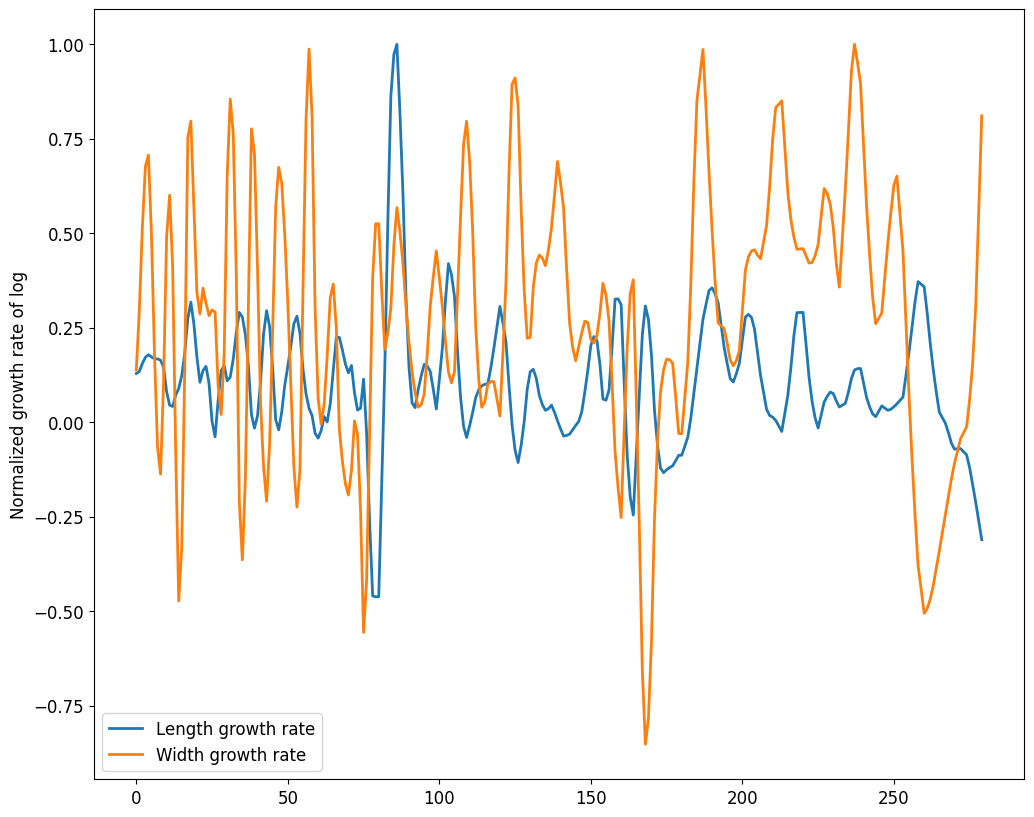

In [8]:
from scipy import signal

idx = 40
s = conditions_struct[0]['body_seg_str_log_length_growth_rate_rescaled'][idx][20:300]
l = conditions_struct[0]['body_seg_str_log_width_mean_growth_rate_rescaled'][idx][20:300]

plt.plot(s/np.max(s))
plt.plot(l/np.max(l))
plt.legend(['Length growth rate', 'Width growth rate'])
plt.ylabel('Normalized growth rate of log')
plt.show()

In [9]:
import numpy
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.linalg import norm
from scipy.stats import spearmanr, pearsonr


def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

def plot_autocorrelation(conditions_struct, series_name, conditions_to_plot, lags,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series = condition[series_name]

        # valid_indices = np.r_[10:70, 110:170, 210:270, 310:370]
        # # set non valid indices to nan
        # series = series[:, valid_indices]

        autocorr = []

        for j in range(series.shape[0]):
            autocorr.append(autocorr1(series[j], lags))
        
        autocorr = np.array(autocorr)

        autocorr_mean = np.nanmean(autocorr, axis=0)
        autocorr_std = np.nanstd(autocorr, axis=0)
        autocorr_ste = autocorr_std / np.sqrt(autocorr.shape[0])

        label = build_legend(condition, legend)

        plt.fill_between(lags, autocorr_mean - 1.96 * autocorr_ste, autocorr_mean + 1.96 * autocorr_ste, alpha=0.5, color=color_palette[i])
        plt.plot(lags, autocorr_mean, label=label, color=color_palette[i])

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

def plot_cross_correlation(conditions_struct, series_one_name, series_two_name, conditions_to_plot,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    mode='same',
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series_one = condition[series_one_name]
        series_two = condition[series_two_name]

        cross_corr = []
        for j in range(series_one.shape[0]):
            norm_series_one = np.linalg.norm(series_one[j])
            norm_series_two = np.linalg.norm(series_two[j])

            normalized_series_one = series_one[j] / norm_series_one
            normalized_series_two = series_two[j] / norm_series_two
            cross_corr.append(signal.correlate(normalized_series_one, normalized_series_two, mode=mode))
            # corr = signal.correlate(series_one[j], series_two[j], mode=mode)
            # cross_corr.append(corr)
            # cross_corr.append(correlate(series_one[j], series_two[j], mode=mode))

        
        cross_corr = np.array(cross_corr)

        cross_corr_mean = np.nanmean(cross_corr, axis=0)
        cross_corr_std = np.nanstd(cross_corr, axis=0)
        cross_corr_ste = cross_corr_std / np.sqrt(cross_corr.shape[0])

        print(cross_corr_mean.shape)
        # Calculate proper x-axis values
        if mode == 'full':
            lags = np.arange(-cross_corr_mean.shape[0] // 2, cross_corr_mean.shape[0] // 2)
        else:  # mode == 'same'
            lags = np.arange(-(cross_corr_mean.shape[0] // 2), cross_corr_mean.shape[0] // 2)

        label = build_legend(condition, legend)

        plt.fill_between(lags,cross_corr_mean - 1.96 * cross_corr_ste, cross_corr_mean + 1.96 * cross_corr_ste, alpha=0.5, color=color_palette[i])
        plt.plot(lags,cross_corr_mean, label=label, color=color_palette[i])

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

def plot_spearman_correlation(
    conditions_struct,
    series_one_name,
    series_two_name,
    conditions_to_plot,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    log_scale=False,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series_one = condition[series_one_name]
        series_two = condition[series_two_name]

        corr = []
        
        for j in range(series_one.shape[0]):
            # select slice of series_one and series_two, from 0 to 80, 110 to 180, 210 to 280, 310 to 380
            selected_indices = np.r_[10:70, 110:170, 210:270, 310:370]
            # selected_indices = np.r_[80:100, 180:200, 280:300, 380:400]
            selected_series_one = series_one[j][selected_indices]
            selected_series_two = series_two[j][selected_indices]

            # selected_series_one = series_one[j]
            # selected_series_two = series_two[j]

            corr.append(spearmanr(selected_series_one, selected_series_two)[0])
 
        selected_indices = np.r_[20:70, 120:170, 220:270, 320:370]

        series_one_values = np.array(series_one)
        series_two_values = np.array(series_two)

        # remove nans
        nan_indices = np.isnan(series_one_values).any(axis=1) | np.isnan(series_two_values).any(axis=1)
        series_one_values = series_one_values[~nan_indices]
        series_two_values = series_two_values[~nan_indices]

        series_one_values = series_one_values[:, selected_indices]
        series_two_values = series_two_values[:, selected_indices]

        series_one_values = series_one_values.flatten()
        series_two_values = series_two_values.flatten()

        # linear regression
        x = series_one_values
        y = series_two_values
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()

        print(spearmanr(series_one_values, series_two_values))
        print(pearsonr(series_one_values, series_two_values))
        print(f'R^2: {results.rsquared}')
        # plt.scatter(series_one_values, series_two_values, color=color_palette[i], alpha=0.5)
        # plt.plot(series_one_values, results.params[0] + results.params[1] * series_one_values, color=color_palette[i], label=f"y = {results.params[0]:.2f} + {results.params[1]:.2f}x")
        # plt.show()

        corr = np.array(corr)
        corr_mean = np.nanmean(corr)
        corr_std = np.nanstd(corr)
        corr_ste = corr_std / np.sqrt(corr.shape[0])

        label = build_legend(condition, legend)

        plt.errorbar(i, corr_mean, yerr=1.96 * corr_ste, fmt='o', color=color_palette[i], label=label)

    plt.xticks(range(len(conditions_to_plot)), [conditions_struct[i]['description'] for i in conditions_to_plot], rotation=45)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

(400,)
(400,)


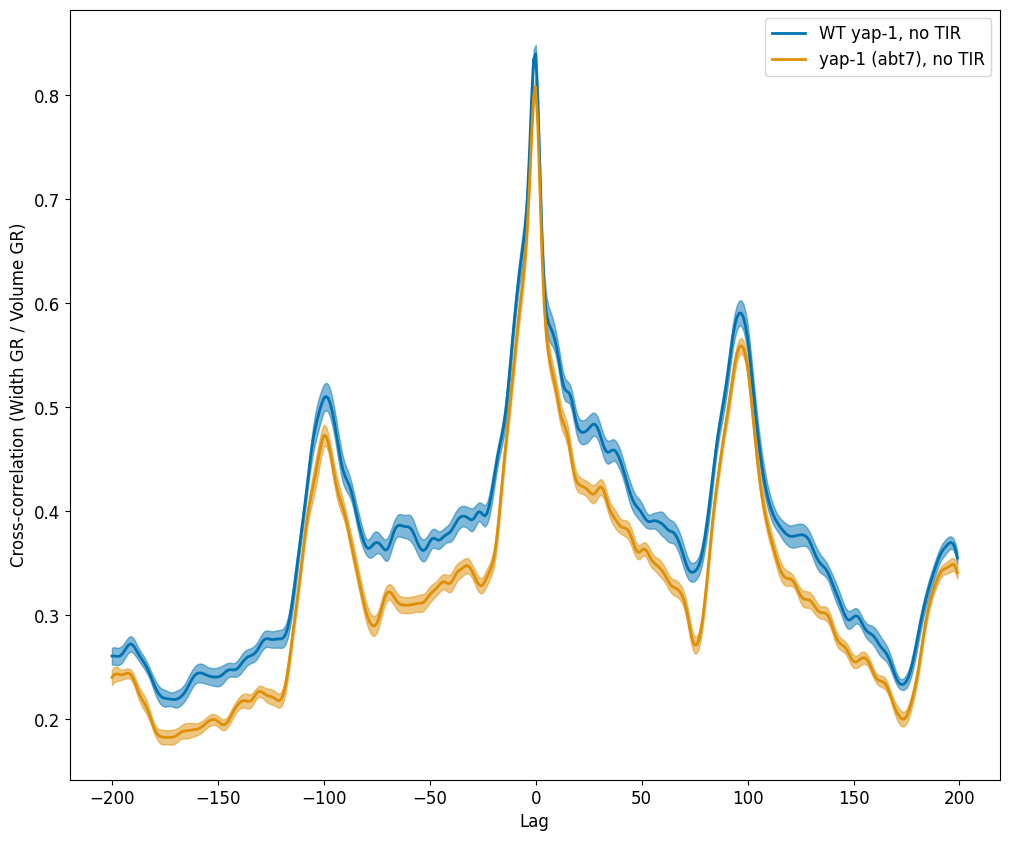

(400,)
(400,)


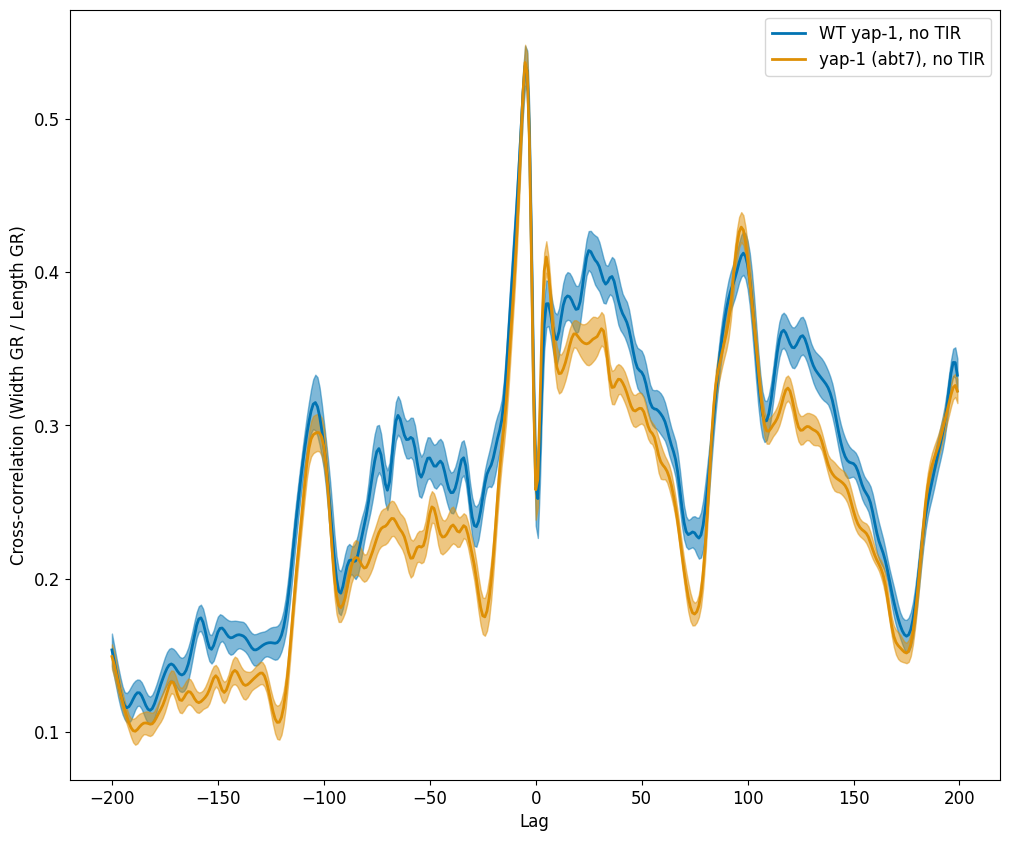

In [10]:
plot_cross_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Volume GR)', legend={'description': ''})
plot_cross_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_length_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Length GR)', legend={'description': ''})

SignificanceResult(statistic=0.5427248779090244, pvalue=0.0)
PearsonRResult(statistic=0.5864529983953412, pvalue=0.0)
R^2: 0.34392711932688447
SignificanceResult(statistic=0.5461674893014604, pvalue=0.0)
PearsonRResult(statistic=0.56278846309985, pvalue=0.0)
R^2: 0.3167308541982913


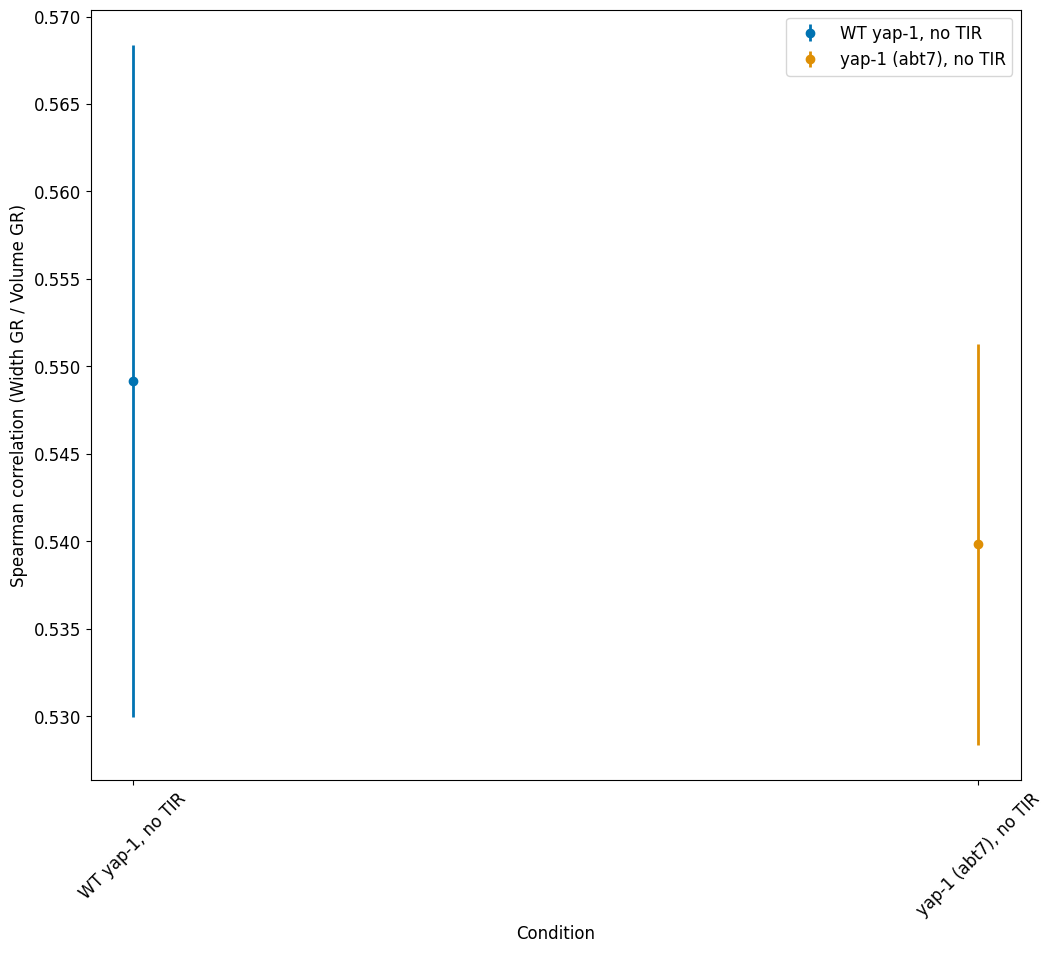

SignificanceResult(statistic=0.06825183628477323, pvalue=1.21095636638736e-07)
PearsonRResult(statistic=0.052158976257409284, pvalue=5.296862670454042e-05)
R^2: 0.0027205588042207296
SignificanceResult(statistic=0.0705335072056483, pvalue=2.7036422949397945e-08)
PearsonRResult(statistic=0.06808556450745293, pvalue=8.04086636194268e-08)
R^2: 0.004635644094298619


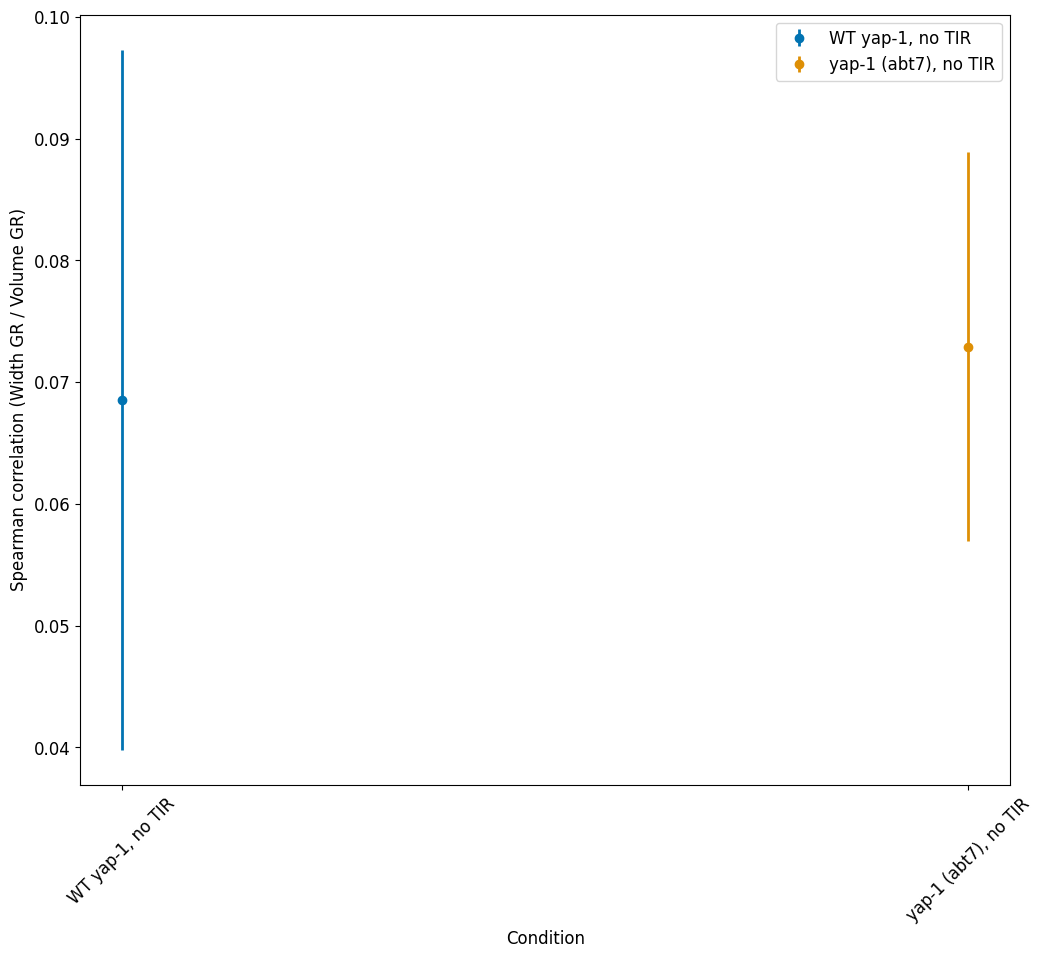

SignificanceResult(statistic=-0.546636739295465, pvalue=0.0)
PearsonRResult(statistic=-0.5648948344155124, pvalue=0.0)
R^2: 0.31910617394932705
SignificanceResult(statistic=-0.5336153873670547, pvalue=0.0)
PearsonRResult(statistic=-0.5719575314799404, pvalue=0.0)
R^2: 0.3271354178166257


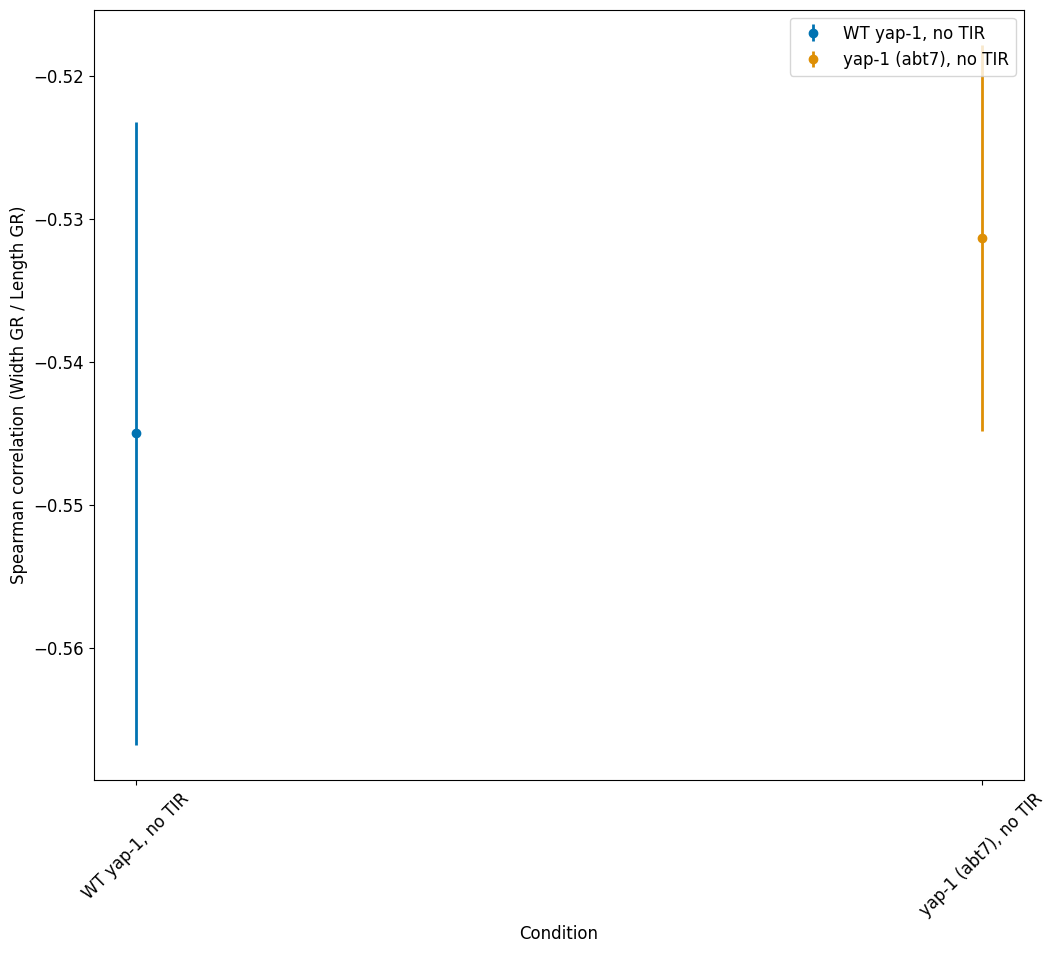

In [11]:
plot_spearman_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], x_axis_label='Condition', y_axis_label='Spearman correlation (Width GR / Volume GR)', legend={'description': ''})
plot_spearman_correlation(conditions_struct, 'body_seg_str_log_length_growth_rate_rescaled', 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], x_axis_label='Condition', y_axis_label='Spearman correlation (Width GR / Volume GR)', legend={'description': ''})
plot_spearman_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_length_growth_rate_rescaled', [0, 4], x_axis_label='Condition', y_axis_label='Spearman correlation (Width GR / Length GR)', legend={'description': ''})

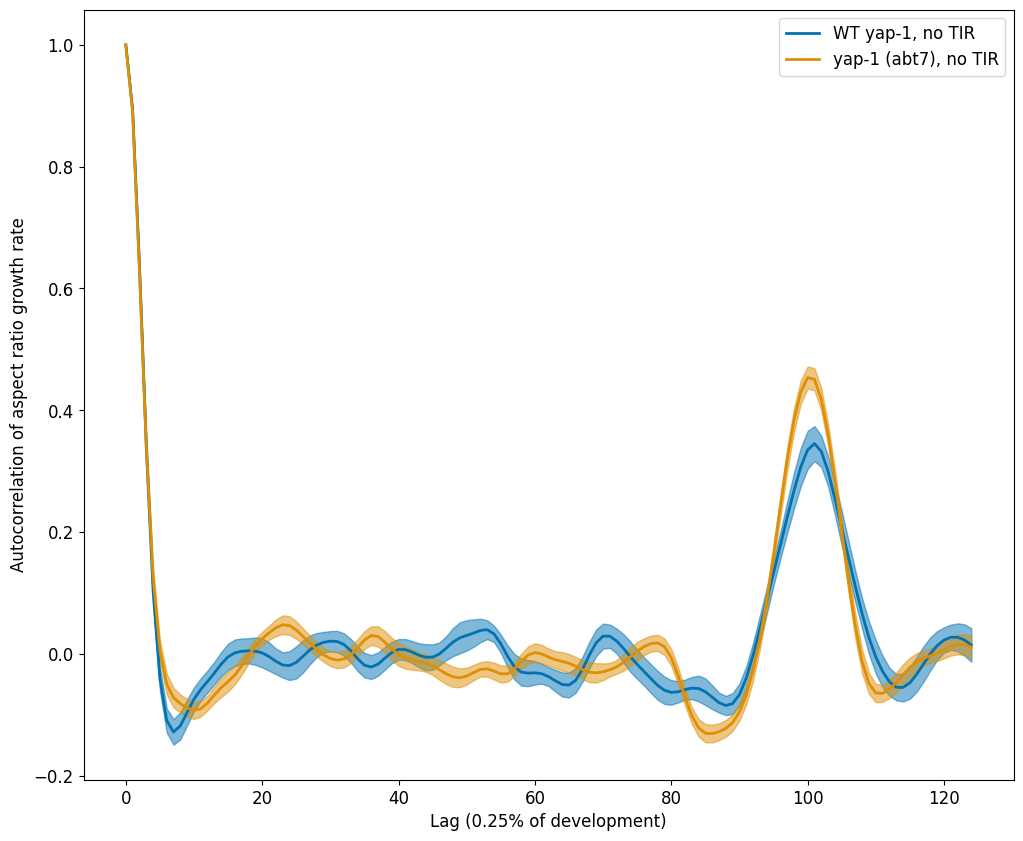

In [12]:
lags = np.arange(0, 125, 1)
plot_autocorrelation(conditions_struct, 'body_seg_str_log_length_growth_rate_rescaled', [0, 4], lags, x_axis_label='Lag (0.25% of development)', y_axis_label='Autocorrelation of aspect ratio growth rate', colors=None, legend={'description': ''})

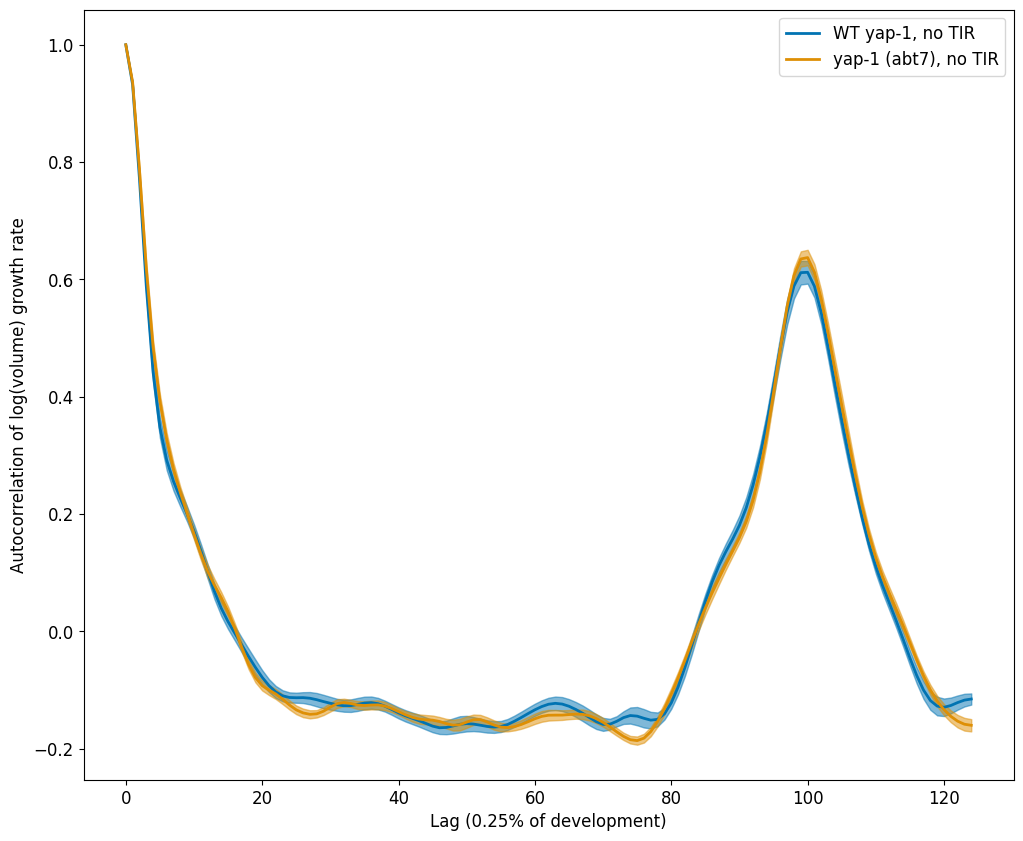

In [13]:
plot_autocorrelation(conditions_struct, 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], lags, x_axis_label='Lag (0.25% of development)', y_axis_label='Autocorrelation of log(volume) growth rate', colors=None, legend={'description': ''})

In [14]:
# conditions_to_plot = [0, 2, 4]
# colors = None
# # colors = ['blue']
# # colors += sns.color_palette("Blues", len(conditions_to_plot) - 1)

# plot_correlation(conditions_struct, 'body_seg_str_length', 'body_seg_str_width_mean', conditions_to_plot, log_scale = (False, True), legend = {'description': ''}, colors = colors)

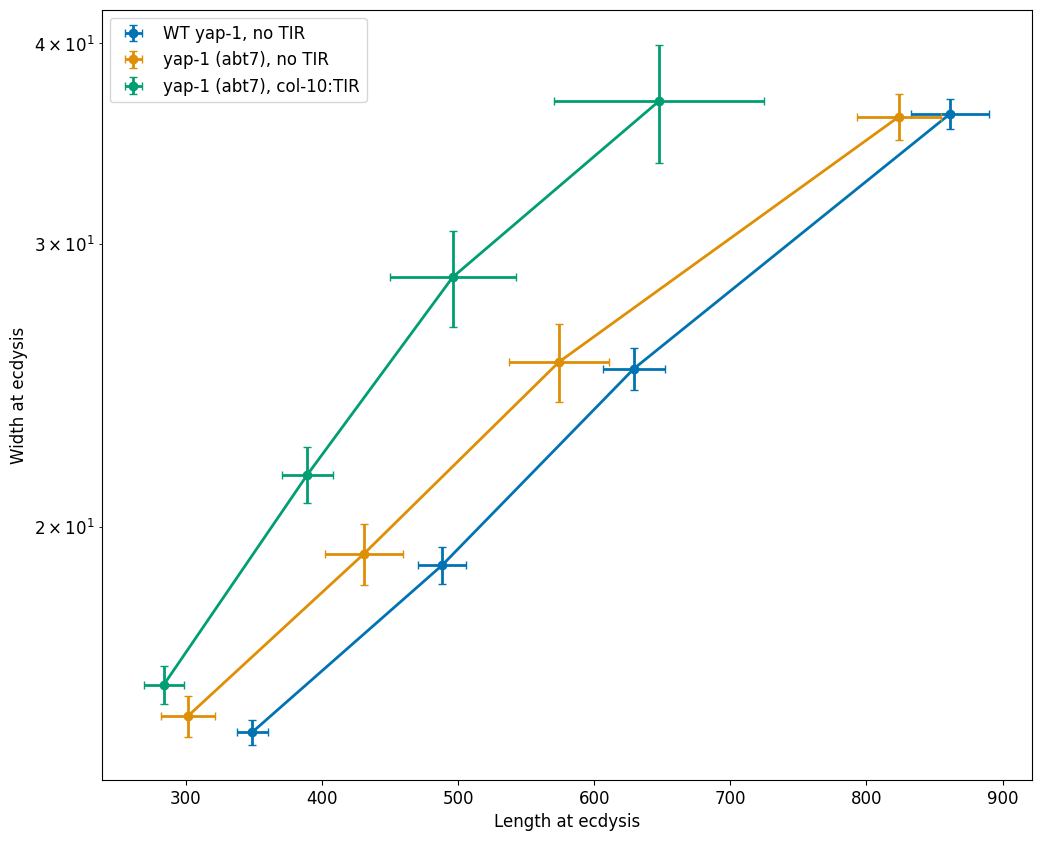

In [15]:
conditions_to_plot = [0, 4, 5]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (False, True), legend = {'description': ''}, y_axis_label='Width at ecdysis', x_axis_label='Length at ecdysis')

In [16]:
# boxplot_at_molt(conditions_struct, 'larval_stage_durations_time_step', [0, 1, 2, 3], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Larval stage duration (time step)", titles = ['L1', 'L2', 'L3', 'L4'])

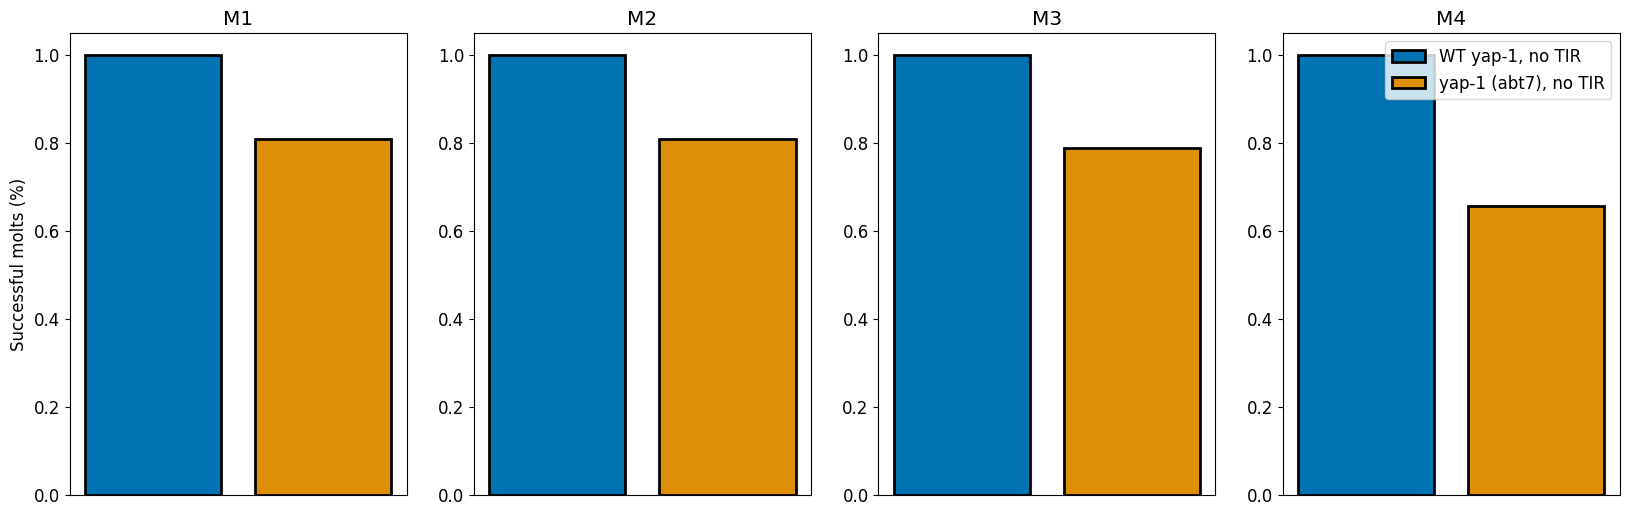

In [17]:
plot_developmental_success(conditions_struct, [0, 4], legend = {'description': ''})

In [18]:
# plot_arrests(conditions_struct, [0, 2, 4, 5], legend = {'description': ''})

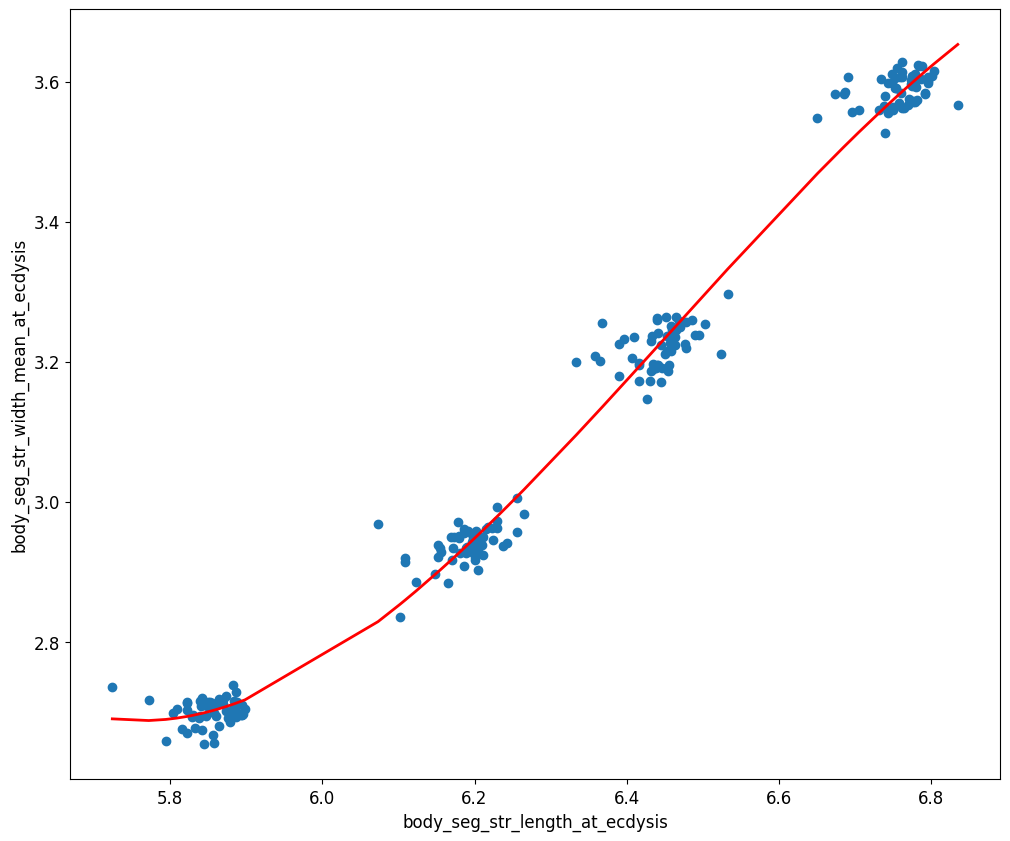

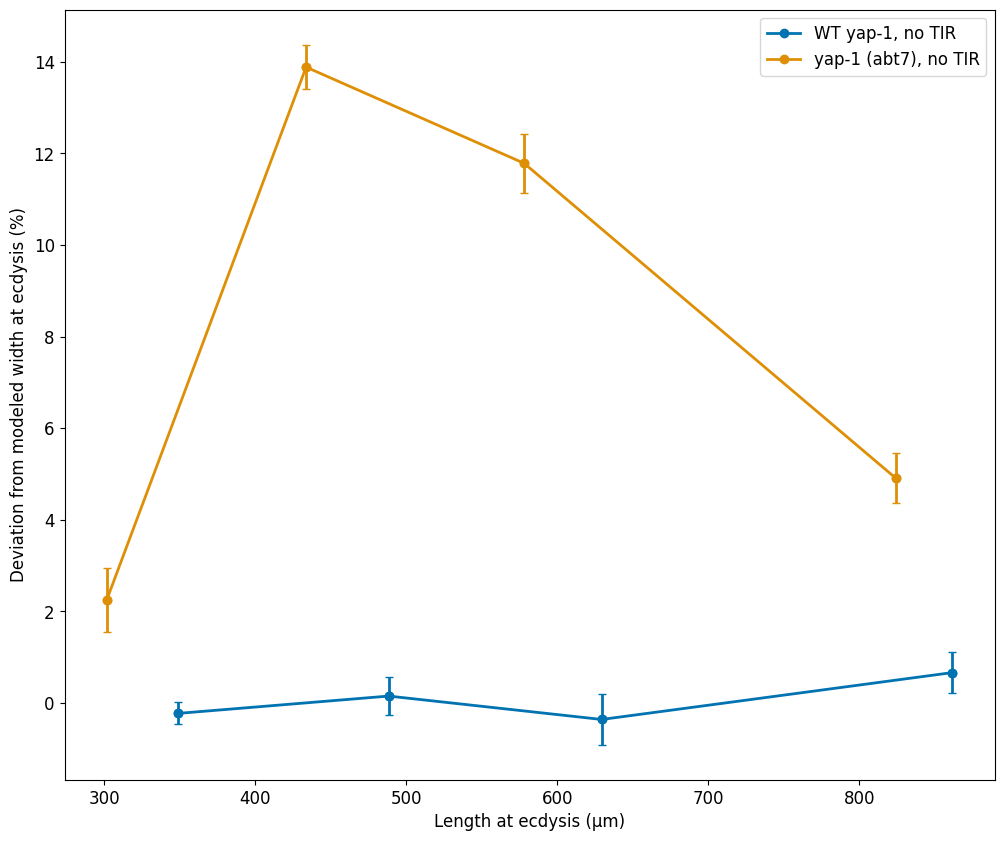

In [19]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_width_mean_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled width at ecdysis (%)')

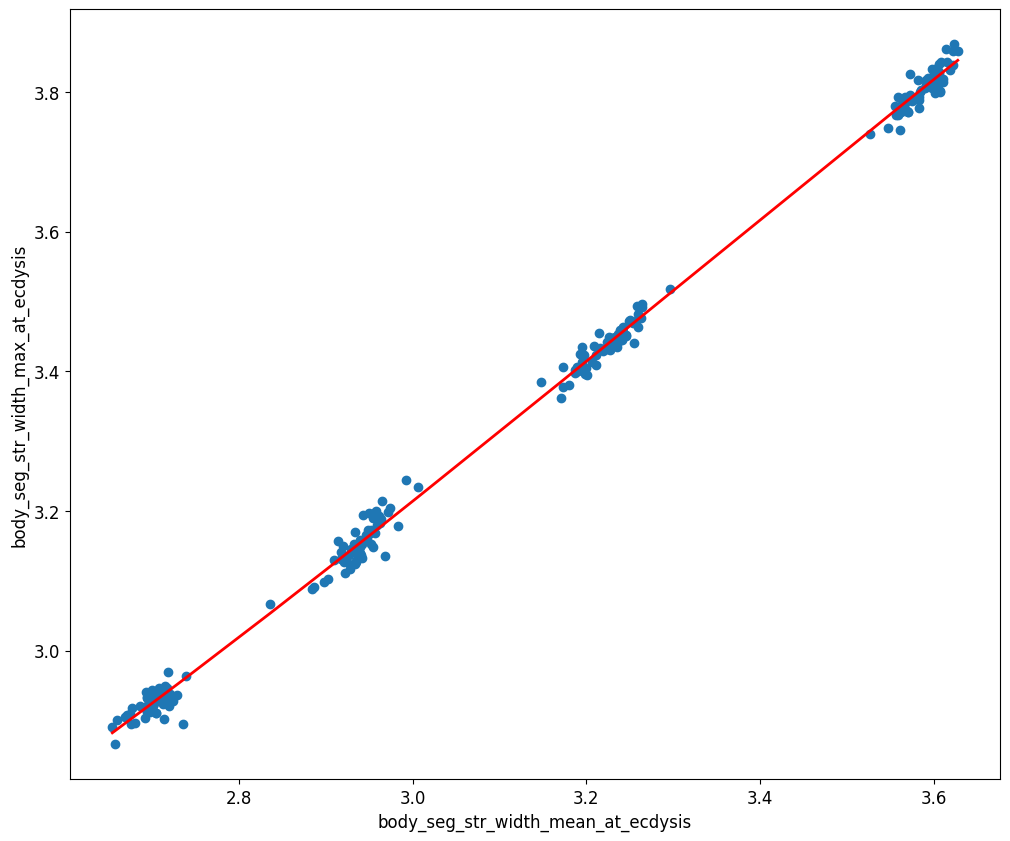

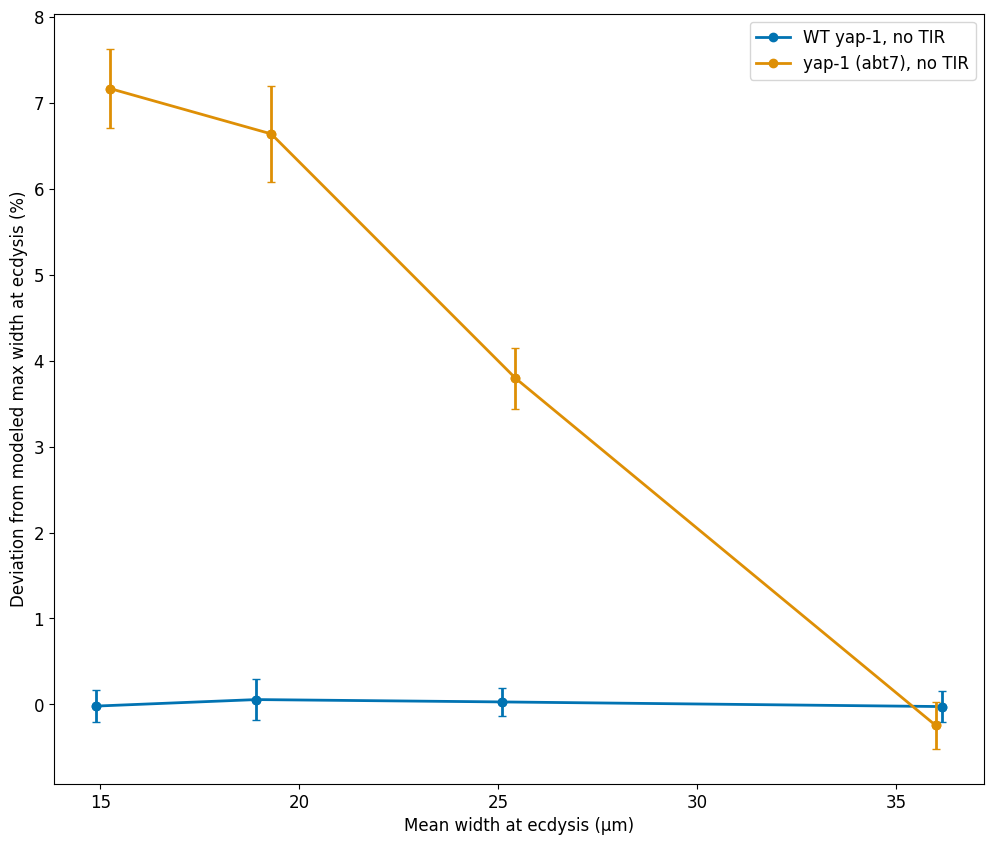

In [20]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_width_mean_at_ecdysis", "body_seg_str_width_max_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

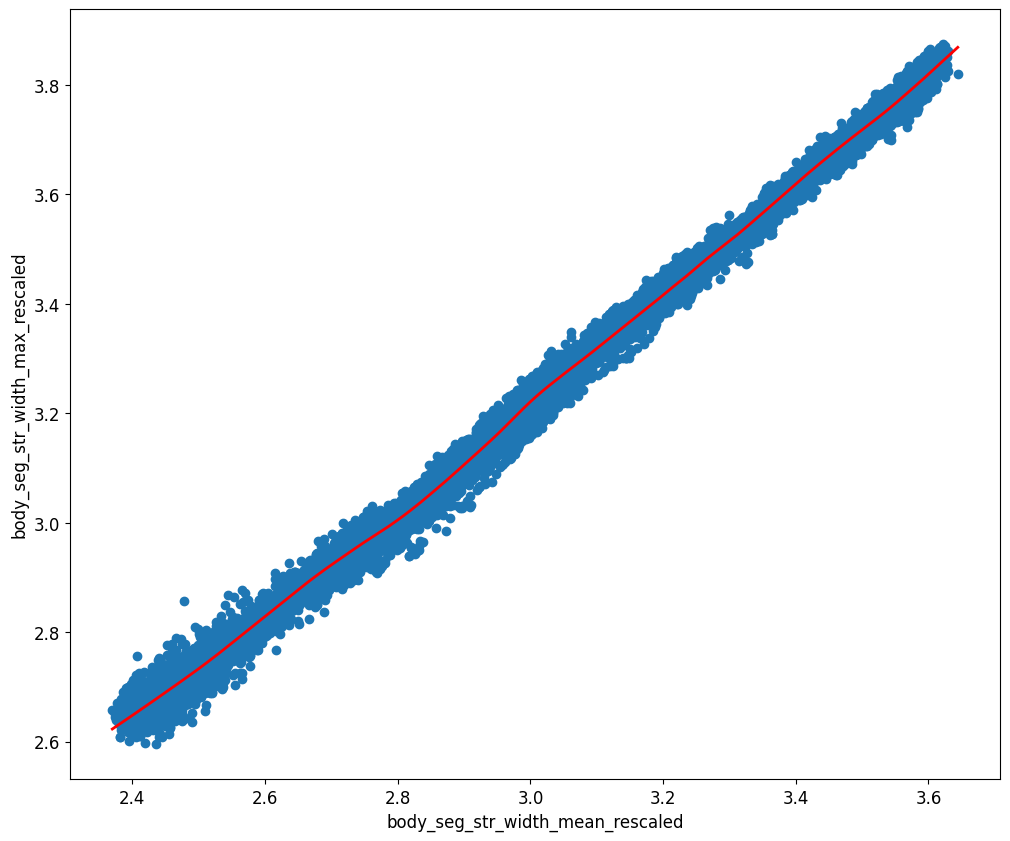

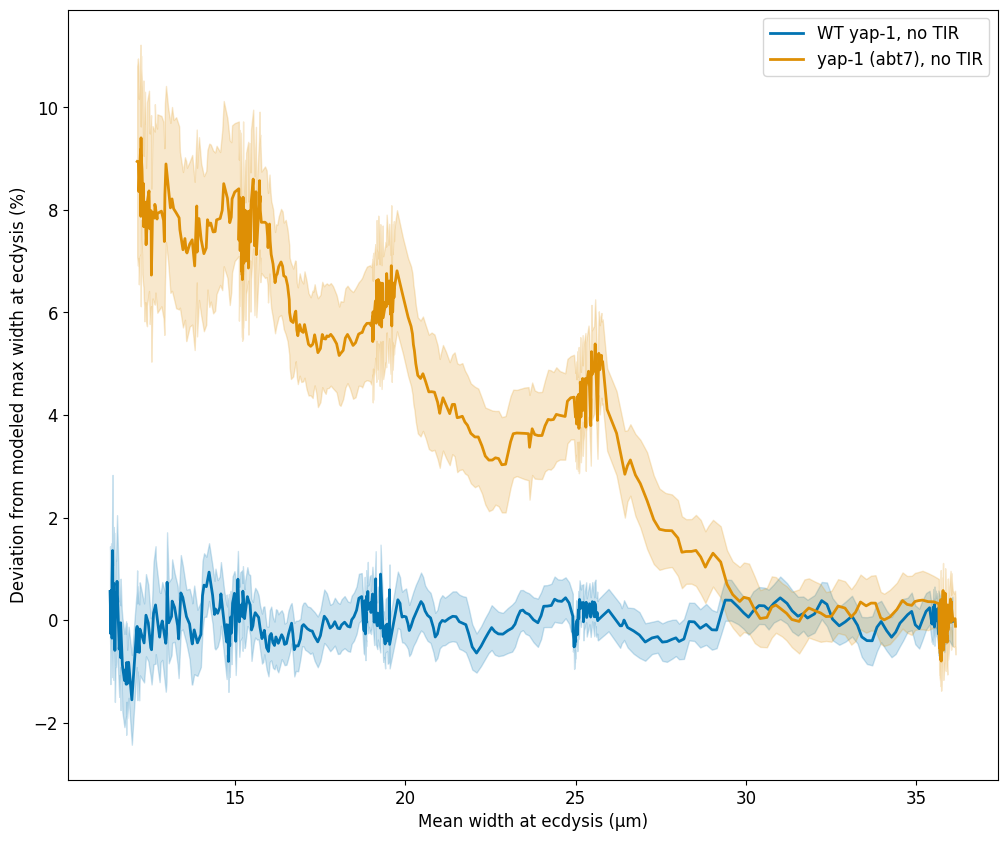

In [21]:
plot_deviation_from_model(conditions_struct, "body_seg_str_width_mean_rescaled", "body_seg_str_width_max_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

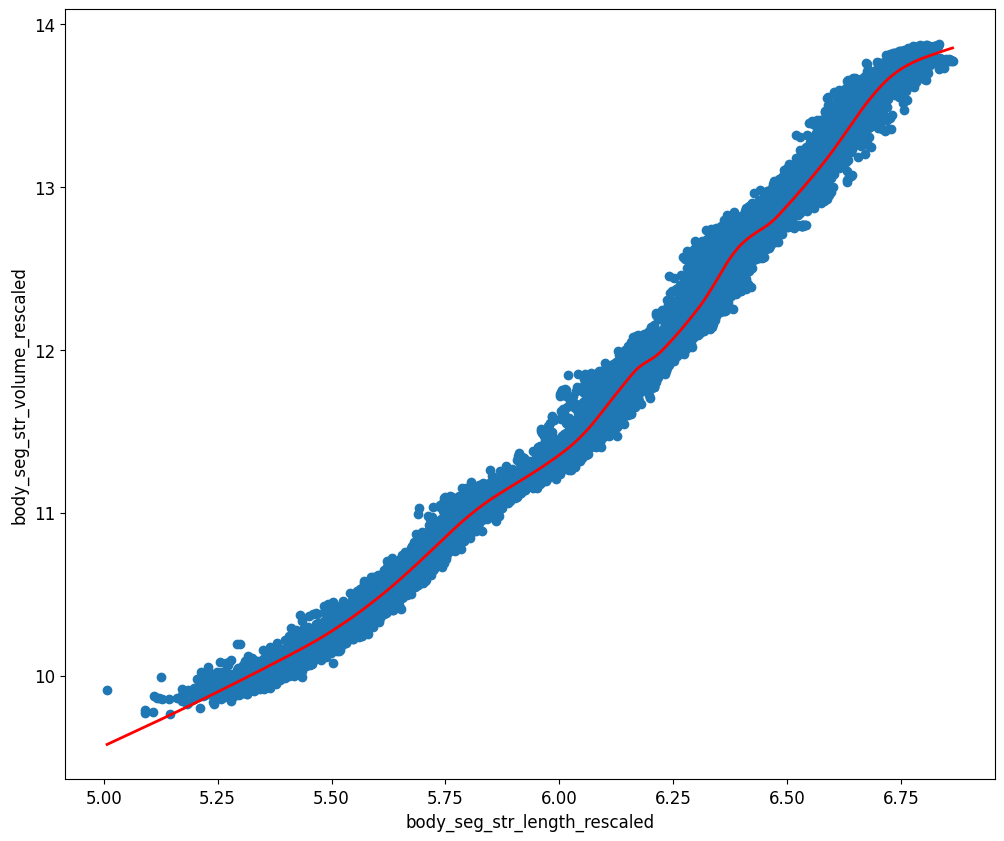

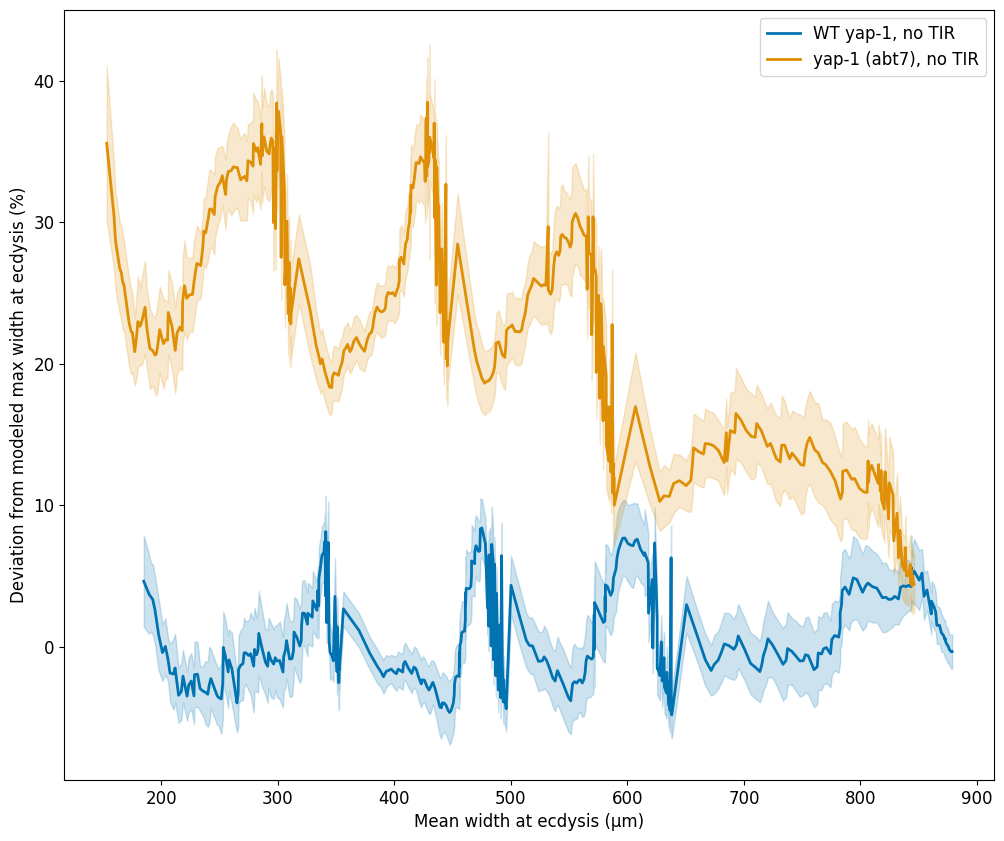

In [22]:
conditions_to_plot = [0, 4]
plot_deviation_from_model(conditions_struct, "body_seg_str_length_rescaled", "body_seg_str_volume_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

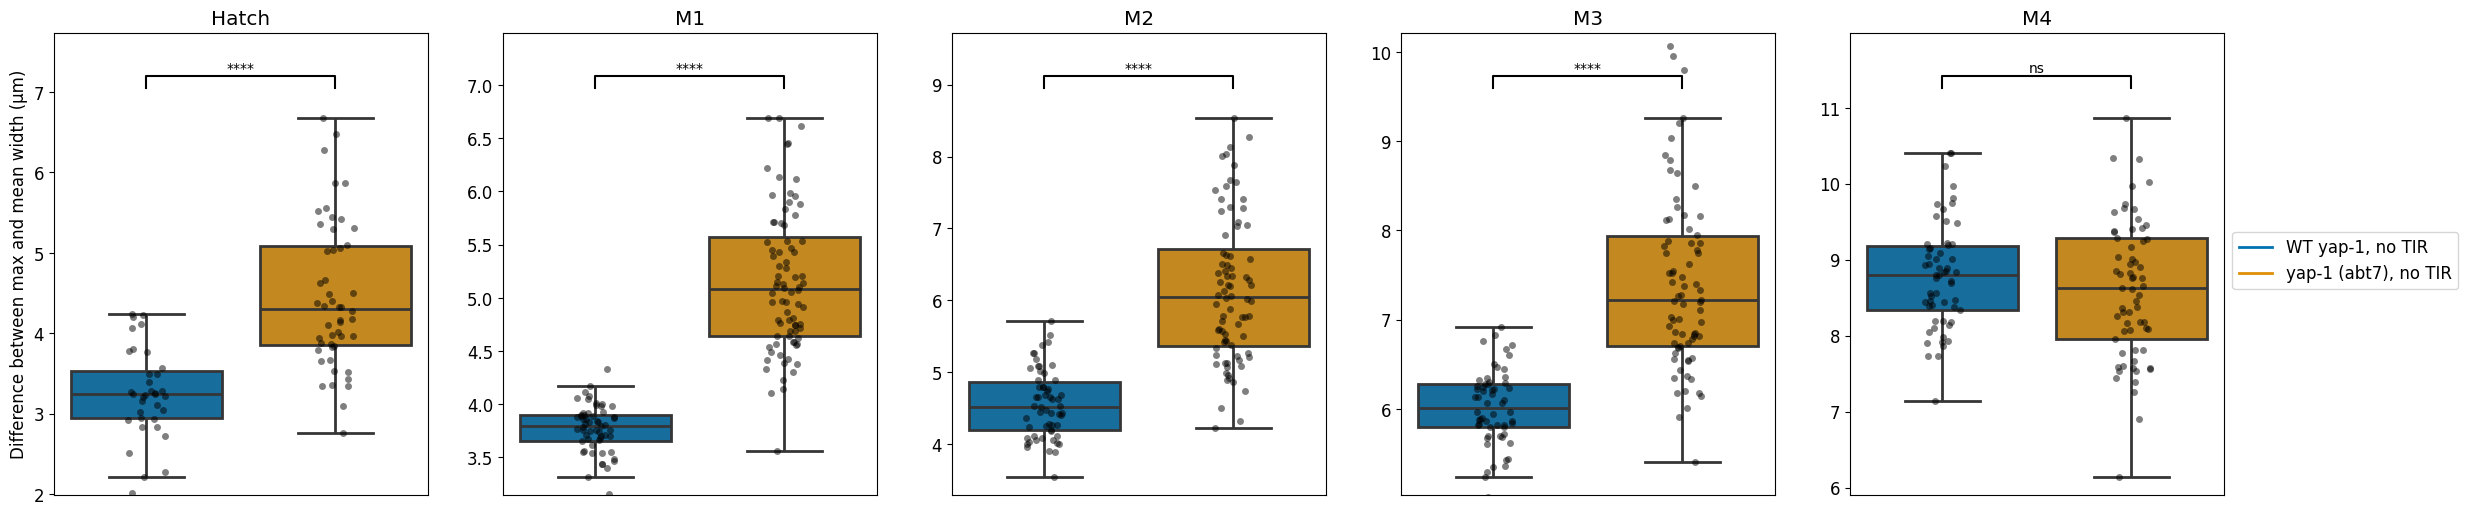

In [23]:
boxplot_at_molt(conditions_struct, 'body_seg_str_width_max_minus_mean_at_ecdysis', [0, 4], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Difference between max and mean width (µm)", titles = ['Hatch', 'M1', 'M2', 'M3', 'M4'])

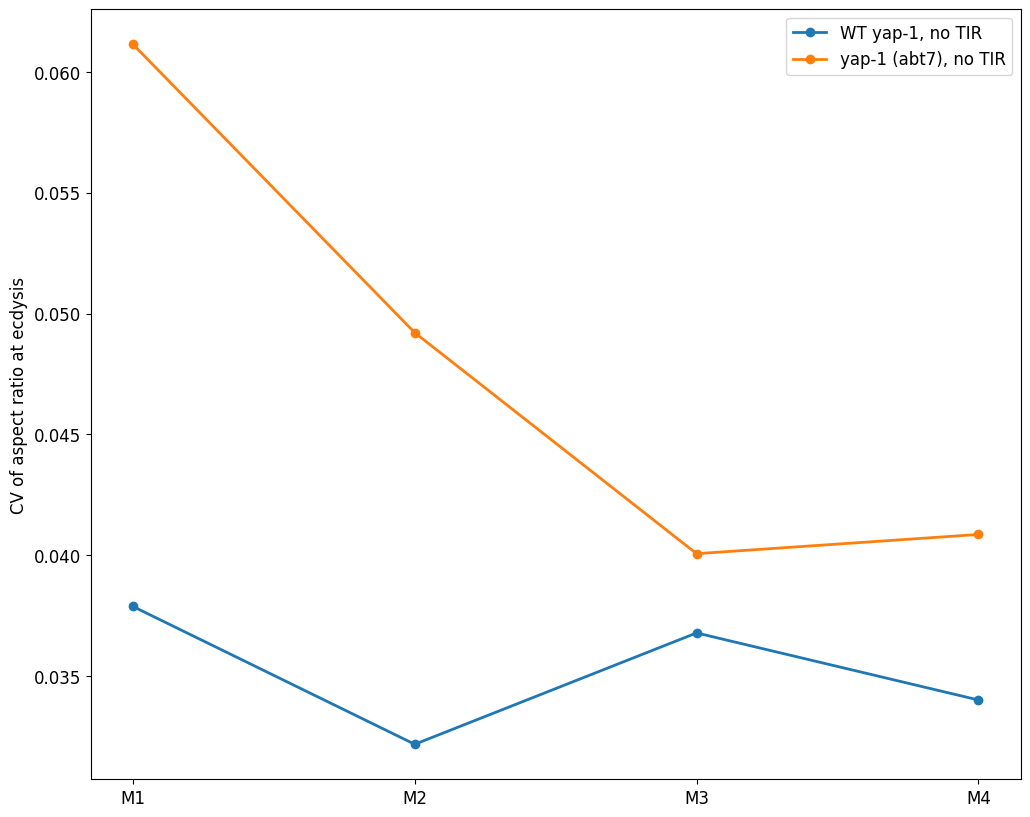

In [24]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_aspect_ratio_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of aspect ratio at ecdysis')   

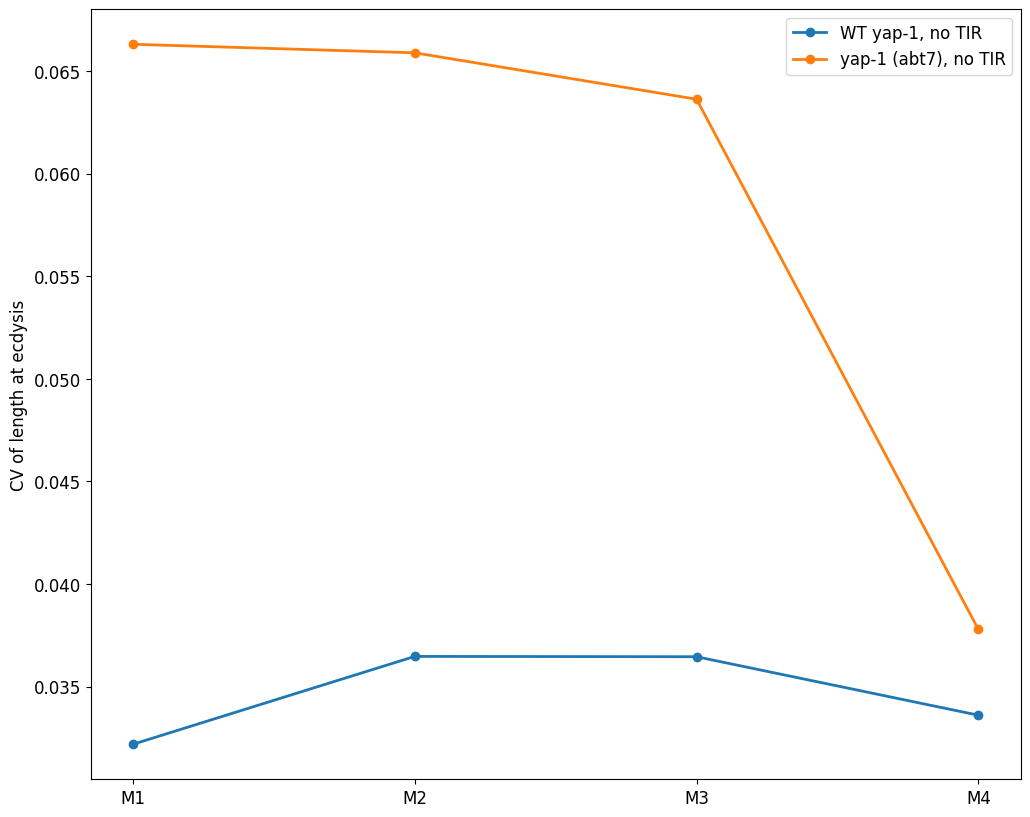

In [25]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length at ecdysis')   

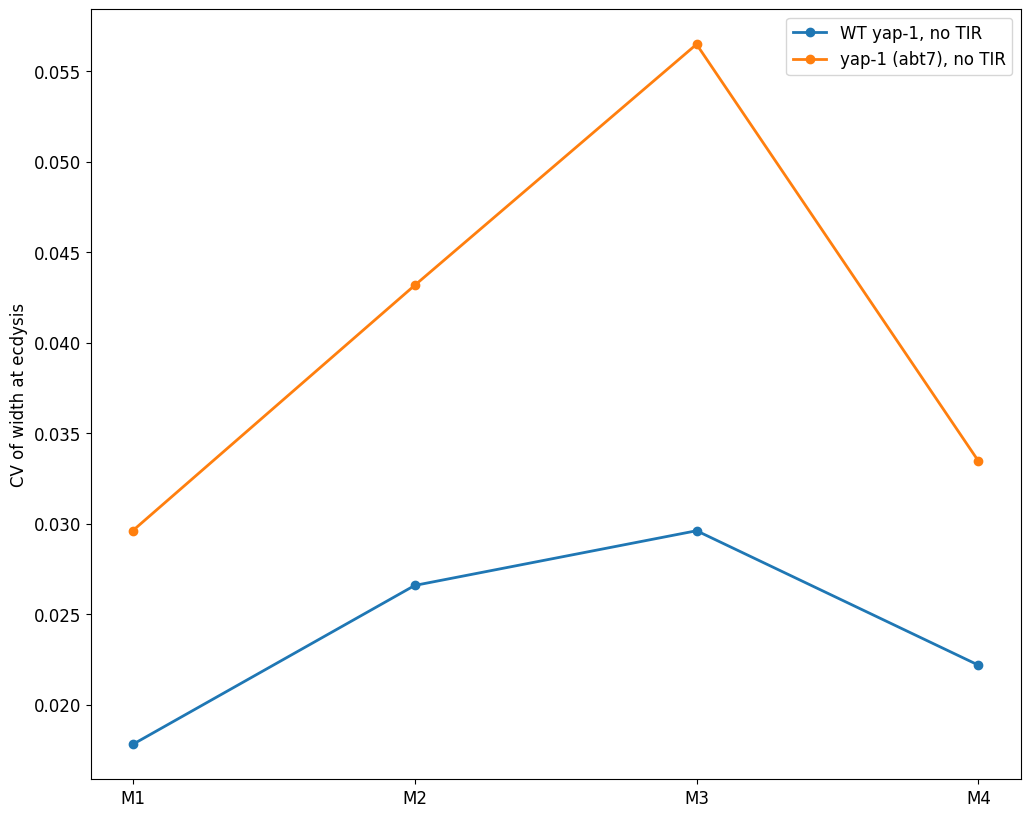

In [26]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width at ecdysis')   

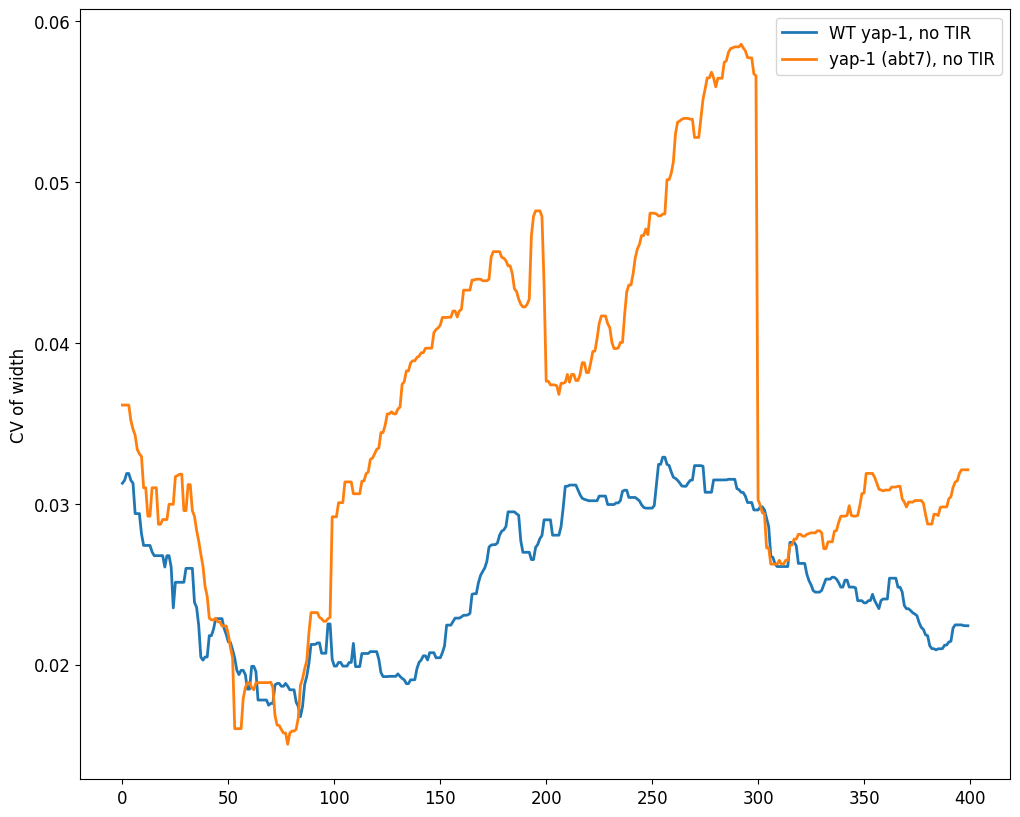

In [27]:
from typing import Dict, List, Tuple, Any

def plot_heterogeneity_rescaled_data(
    conditions_struct: Dict,
    column: str,
    conditions_to_plot: List[int], 
    smooth: bool = False,
    remove_hatch = True, 
    legend = None, 
    x_axis_label = None, 
    y_axis_label = None, 
    exclude_arrests: bool = False,):
    for condition in conditions_to_plot:
        condition_dict = conditions_struct[condition]

        values = condition_dict[column]
        cvs = np.nanstd(values, axis=0) / np.nanmean(values, axis=0)
        label = build_legend(condition_dict, legend)

        if smooth:
            cvs = medfilt(cvs, 7)
            # cvs = savgol_filter(cvs, 15, 3)

        plt.plot(cvs, label = label)

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    plt.legend()

    plt.show()

plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_width_mean_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width')   

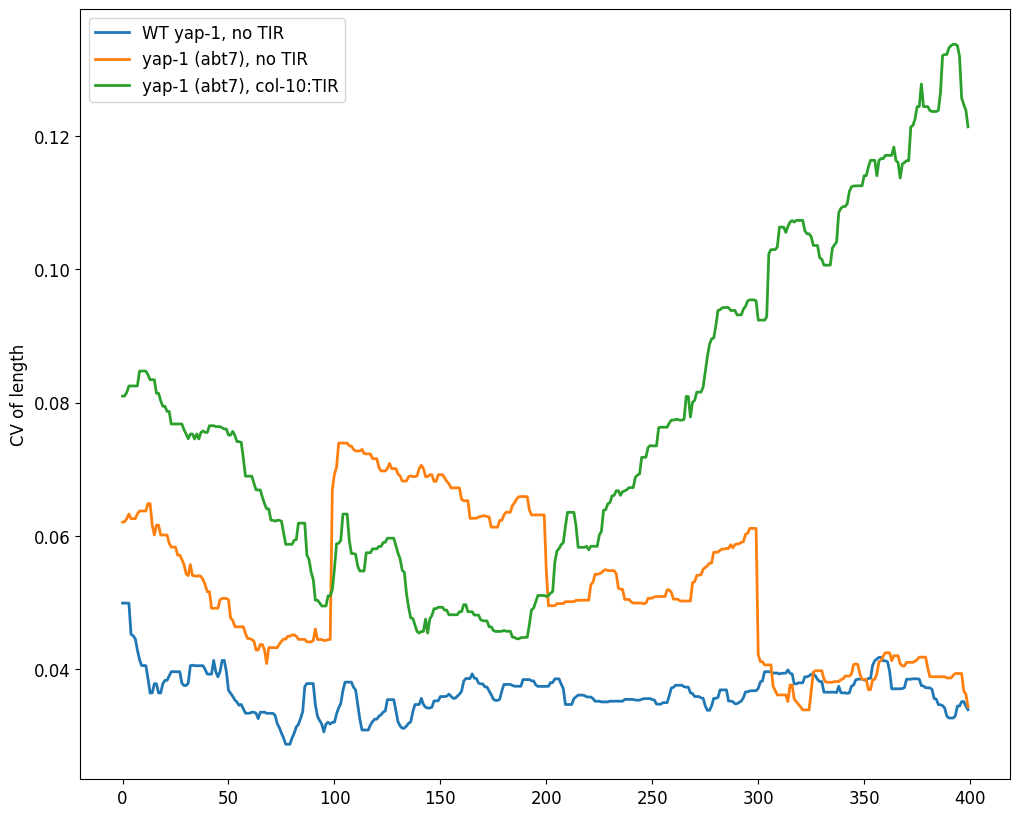

In [35]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_length_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length') 

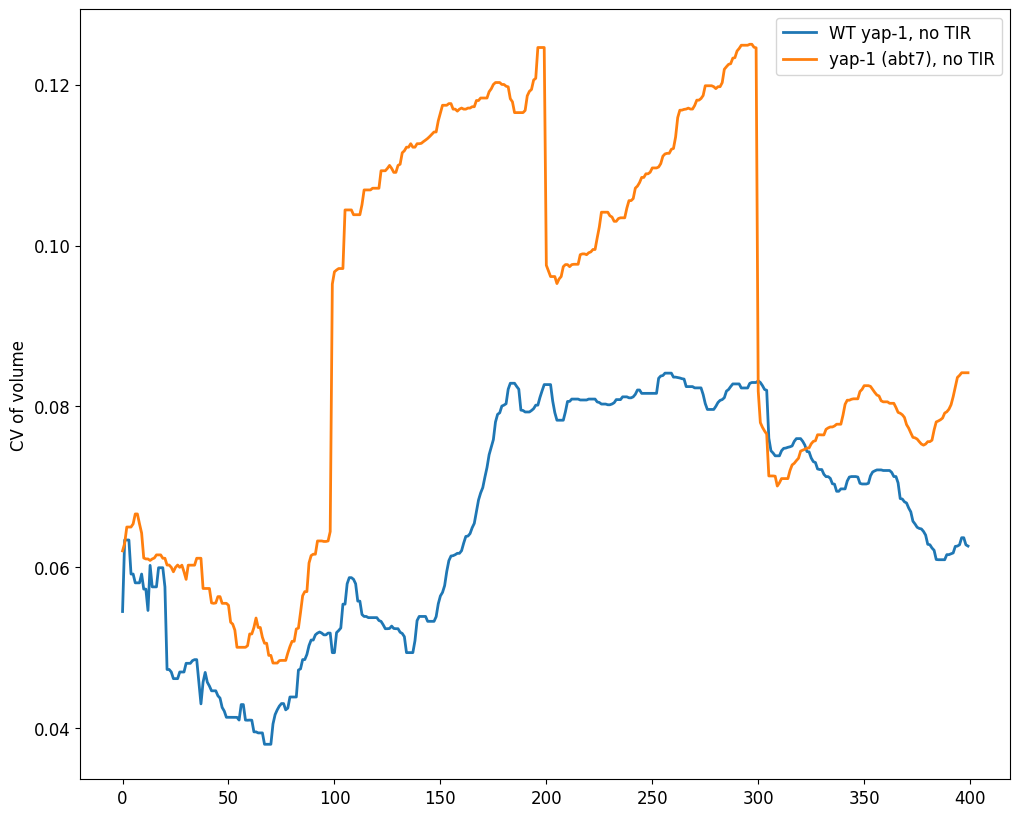

In [29]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_volume_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume') 

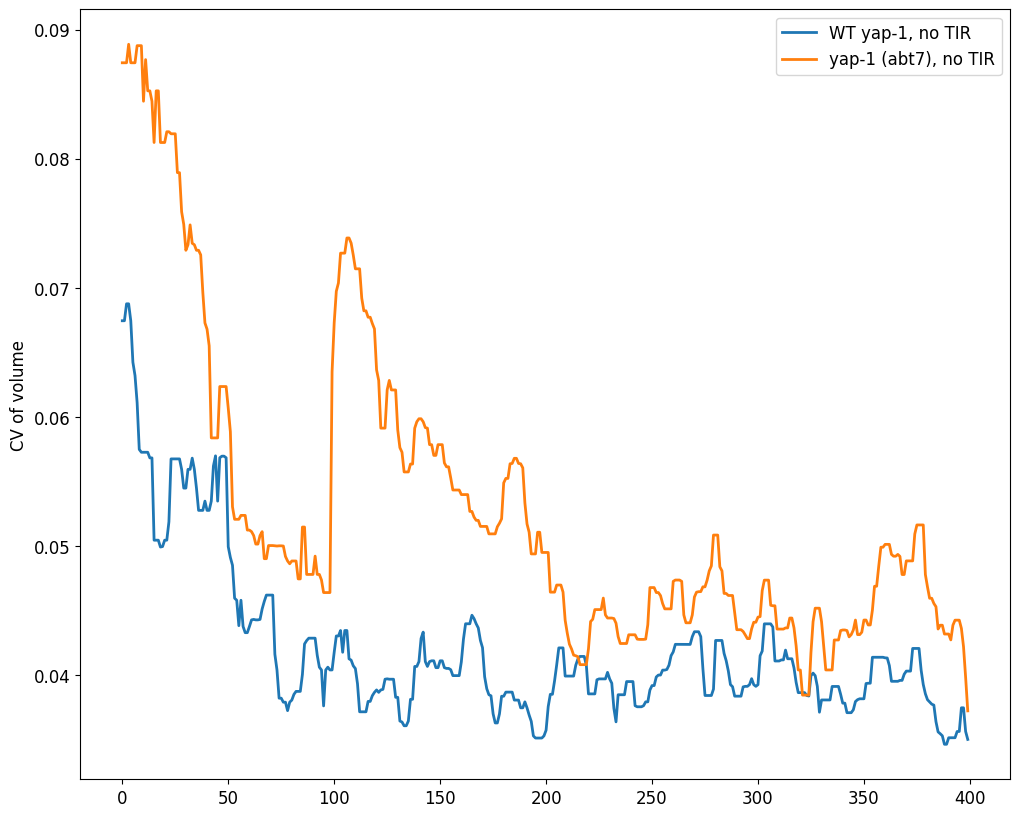

In [30]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_aspect_ratio_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume') 

In [31]:
# get_most_average_size_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_width_mean_at_ecdysis',
#     ['analysis_sacha/ch2_seg_str'],
#     [4],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red'],
# )

In [32]:
# get_most_average_size_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_volume_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [4],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )

In [33]:
# get_most_average_proportions_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_length_at_ecdysis',
#     'body_seg_str_mean_width_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [0],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )

In [34]:
# get_most_average_proportions_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_length_at_ecdysis',
#     'body_seg_str_volume_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [5],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )